# Using a Restricted Boltzmann Machine for feature extraction from an image-based dataset

In [1]:
# Make code toggle-able for easier review.
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<i>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a></i>.''')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.ndimage import convolve


from sklearn.neural_network import BernoulliRBM


import seaborn as sns

<hr>

# Overview & dataset

### The <a href='https://www.kaggle.com/zalando-research/fashionmnist/home'>fashion MNIST</a> contains 70,000 28x28 labeled fashion images spanning 10 categories. 60,000 images are included in the training set, and 10,000 in the test set. Each row in the raw CSV represents a 28x28 image, with each column except the class label representing a pixel. 

In [3]:
# Define the filepath and read the data
train = '/Users/guest/Dropbox/Education/Thinkful/Unit 4 - Unsupervised learning/Lesson 3 - Neural networks and deep learning/U4L3P6 - Make your own network/fashionmnist/fashion-mnist_train.csv'
df = pd.read_csv(train)

df.head(1)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<br>
### The category labels and a raw example image from each class are reproduced below

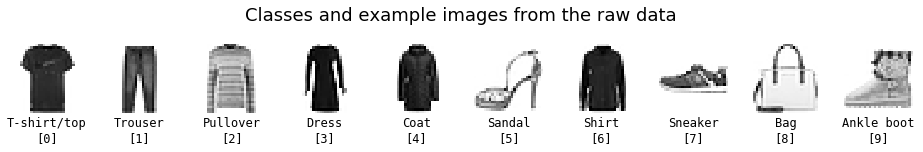

In [4]:
### Visualizing the categories

# Define the category labels
cat_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

def plot_classes(column, title='Images'):
    plt.figure(figsize=(13,4))
    gs = GridSpec(1, 10)
    for label in range(0,10):    
        ax = plt.subplot(gs[0, 0+label:1+label])
        plt.imshow(list(visualization[visualization['label'] == label][column][0:10])[1], 
                   cmap=plt.cm.Greys)
        plt.title('{}\n[{}]'.format(cat_labels[label], label), y=-0.5, fontsize=12, family='monospace')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        sns.despine(bottom=True, left=True)
    plt.suptitle(title, y=0.75, fontsize=18)
    plt.tight_layout()
    plt.show()
    
# Create a new dataframe with a column of numpy arrays that summarize the pixel data
visualization = pd.DataFrame()
visualization['label'] = df['label']
visualization['images_raw'] = list(item for item in df.as_matrix(columns=df.columns[1:]))
visualization['images_raw'] = visualization['images_raw'].apply(lambda x: x.reshape(28,28))

# Plot the 
plot_classes('images_raw',
             'Classes and example images from the raw data')
plt.show()

<hr>

# Data preparation

### To prepare the dataset, I first quintupled its size by generating images with 1-pixel shifts in each direction. <a href = 'https://www.pyimagesearch.com/2014/06/16/1-pixel-shifts-images-can-kill-rbm-performance/'>This helps the model build resistance to adversarial images</a>.

### I also min-max rescaled all of the data to convert each greyscale value to a probability – <a href='http://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html'>scikit-learn.BernoulliRBM currently only accepts binary inputs and inputs between 0 and 1</a>.

In [5]:
# Nudge function gleefully stolen from
def nudge_dataset(X, Y):
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((28, 28)), mode='constant',
                                  weights=w).ravel()
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

# Define X
X = np.array(df.loc[:, df.columns != 'label'])
print('The raw dataset contains {} observations.'.format(X.shape[0]))

# Rescale and nudge X
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001) 
X, Y = nudge_dataset(X, df['label'])
print('With the addition of the nudged data, the dataset contains {} observations.'.format(X.shape[0]))

The raw dataset contains 60000 observations.
With the addition of the nudged data, the dataset contains 300000 observations.


<hr>

# Generating the features

### I've referred to several sources, particularly <a href='http://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html#sphx-glr-auto-examples-neural-networks-plot-rbm-logistic-classification-py'>this example</a> and  <a href='https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf'>this guide</a> for advice on choosing my hyperparameters, and the only thing very clear to me at this point is that setting these is a complex process that's going to take lots of practice to get a feel for and considerable study to wrap my head around. 

### It seems as though the standard way to select hyperparameters for a Restricted Boltzman Machine – time and computational power permitting – is to use GridSearchCV on a range of values. My computational power does not permit, so I ultimately left most hyperparameters set to their defaults after fiddling with them for a while.

In [6]:
# Instantiate and fit the model
rbm = BernoulliRBM(n_components=100, 
                   learning_rate=0.5,
                   verbose=True)

rbm.fit(X, Y)
rbm_X = rbm.transform(X)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -283.53, time = 76.52s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -290.96, time = 89.04s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -314.88, time = 84.83s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -296.50, time = 88.25s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -310.66, time = 81.66s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -319.67, time = 77.41s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -293.01, time = 75.89s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -327.70, time = 83.91s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -296.02, time = 87.89s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -316.13, time = 85.41s


<br>
### The 100 components created by the RBM are reproduced below.

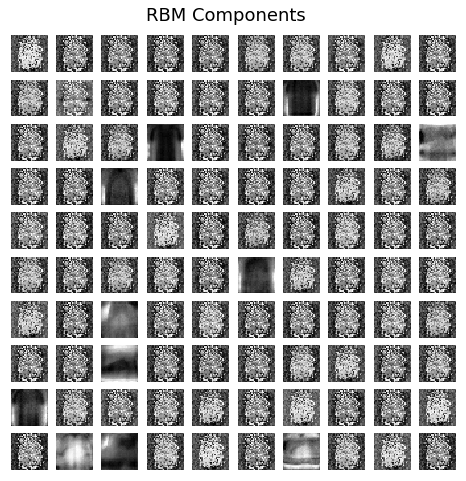

In [60]:
# Retrieve the RBM components
components = rbm.components_

# Plot them 
plt.figure(figsize=(8,8))
for x in range(0,100):
    ax = plt.subplot(10, 10, x + 1)
    plt.imshow(components[x].reshape(28,28), 
               cmap=plt.cm.Greys)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    sns.despine(bottom=True, left=True)

plt.suptitle('RBM Components', y=0.93, fontsize=18)
plt.show()

<hr>

# Overview

###   In this application, RBM was able to condense image data from large arrays of pixels into substantially fewer & more meaningful dimensions, making it more suitable for further modeling.

### Questions
* Many of my components looked like very similar noise, while others very clearly distinguish characteristics of the garments in the dataset. Why is this? Are the components that look like noise actually noise, or is there a layer of abstraction the model is picking up on that my eye is not?
* Are there better methodical ways to set hyperparameters than piping the RBM output into a predictive model and using GridSearchCV? Or is this just something that I have to get a feel for?
* If I wanted to use an RBM to extract features from a less-standardized image dataset, such as a large group of photos that are all different sizes, what would be the best method for preparing that dataset for the machine?